# OSEM- Assignment 3
Aadit Malla

## 1. Adding new technology LED

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

In [3]:
scenario = message_ix.Scenario(
    mp, model="Westeros Electrified", scenario="baseline", version="new"
)

In [4]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon(year=history + model_horizon, firstmodelyear=model_horizon[0])

In [5]:
country = "Westeros"
scenario.add_spatial_sets({"country": country})

In [6]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final","useful"])
scenario.add_set("technology", ["coal_ppl", "wind_ppl","grid","bulb","LED"])#LED added to the technology list
scenario.add_set("mode", "standard")

<AxesSubplot:title={'center':'GDP profile'}, xlabel='Time'>

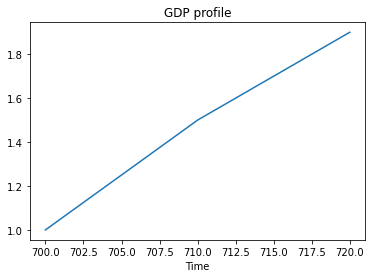

In [7]:
gdp_profile = pd.Series([1.0, 1.5, 1.9], index=pd.Index(model_horizon, name="Time"))
gdp_profile.plot(title="GDP profile")

In [8]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame(
    {
       "node": country,
        "commodity": "light",
        "level": "useful",
        "year": model_horizon,
        "time": "year",
        "value": (demand_per_year * gdp_profile).round(),
        "unit": "GWa",
    }
)
scenario.add_par("demand", light_demand)

In [9]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]

# Some common values to be used for both the "input" and "output" parameters
base = dict(
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    time="year",
    unit="-",
)

# Use the message_ix utility function make_df() to create a base data frame for
# different "input" parameter values
base_input = make_df("input", **base, node_origin=country, time_origin="year")

# Create a base data frame for different "output" parameter values
base_output = make_df("output", **base, node_dest=country, time_dest="year")

In [10]:
## Bulb in this exercise is assumed to be incandescent bulb

bulb_out = base_output.assign(
    technology="bulb", commodity="light", level="useful", value = 1.0
)
scenario.add_par("output", bulb_out)

bulb_in = base_input.assign(
    technology="bulb", commodity="electricity", level="final", value=1.0
)
scenario.add_par("input", bulb_in)

In [11]:
### adding the LED bulb -AM

## LED output is relatively 75% more efficeint than an incandescent bulb. However, the efficeiny increase had
## to be limited to 10%, otherwise the model selects LED in the baseline due to its much higher benifits.

led_out = base_output.assign(
    technology="LED", commodity="light", level="useful", 
    value= 1.1
)
scenario.add_par("output", led_out)

led_in = base_input.assign(
    technology="LED", commodity="electricity", level="final", value=1.0
)

scenario.add_par("input", led_in)

In [12]:
grid_efficiency = 0.9
grid_out = base_output.assign(
    technology="grid",
    commodity="electricity",
    level="final",
    value=grid_efficiency,
)
scenario.add_par("output", grid_out)

grid_in = base_input.assign(
    technology="grid", commodity="electricity", level="secondary", value=1.0
)
scenario.add_par("input", grid_in)

In [13]:
coal_out = base_output.assign(
    technology="coal_ppl",
    commodity="electricity",
    level="secondary",
    value=1.0,
    unit="GWa",
)
scenario.add_par("output", coal_out)

wind_out = base_output.assign(
    technology="wind_ppl",
    commodity="electricity",
    level="secondary",
    value=1.0,
    unit="GWa",
)
scenario.add_par("output", wind_out)

In [14]:
capacity_factor = {
    "coal_ppl": 1,
    "wind_ppl": 0.36,
    "bulb":1,
    "LED":1,
}

for tec, val in capacity_factor.items():
    df = make_df(
        "capacity_factor",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        time="year",
        unit="-",
        technology=tec,
        value=val,
    )
    scenario.add_par("capacity_factor", df)

In [15]:
lifetime = {
    "coal_ppl": 20,
    "wind_ppl": 20,
    "bulb":1,
    "LED":10, ## minimal lifetime
}

for tec, val in lifetime.items():
    df = make_df(
        "technical_lifetime",
        node_loc=country,
        year_vtg=model_horizon,
        unit="y",
        technology=tec,
        value=val,
    )
    scenario.add_par("technical_lifetime", df)

In [16]:
growth_technologies = [
    "coal_ppl",
    "wind_ppl",
]

for tec in growth_technologies:
    df = make_df(
        "growth_activity_up",
        node_loc=country,
        year_act=model_horizon,
        time="year",
        unit="-",
        technology=tec,
        value=0.1,
    )
    scenario.add_par("growth_activity_up", df)

In [17]:
##defining the energy mix

historic_demand = 0.5 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.6

In [18]:
##defining the historic activity

old_activity = {
    "coal_ppl": coal_fraction * historic_generation,
    "wind_ppl": (1 - coal_fraction) * historic_generation,
    "bulb": historic_demand,
    "LED":0, ## LED starts only from 1st year of the horizon
}

for tec, val in old_activity.items():
    df = make_df(
        "historical_activity",
        node_loc=country,
        year_act=history,
        mode="standard",
        time="year",
        unit="GWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("historical_activity", df)

In [19]:
### new capacity
for tec in old_activity:
    value = old_activity[tec] / (1 * 10 * capacity_factor[tec])
    df = make_df(
        "historical_new_capacity",
        node_loc=country,
        year_vtg=history,
        unit="GWa",
        technology=tec,
        value=value,
    )
    scenario.add_par("historical_new_capacity", df)

In [20]:
## interst rate for minimizing costs in objective function

scenario.add_par("interestrate", model_horizon, value=0.05, unit="-")

In [21]:
##INVESTMENT

# Add a new unit for ixmp to recognize as valid
mp.add_unit("USD/kW")

# in $ / kW (specific investment cost)
costs = {
    "coal_ppl": 500,
    "wind_ppl": 1500,
    "bulb":1,
    "LED":500 ## LED is expensive but 500 times is a bit too high**need to fix*
}

for tec, val in costs.items():
    df = make_df(
        "inv_cost",
        node_loc=country,
        year_vtg=model_horizon,
        unit="USD/kW",
        technology=tec,
        value=val,
    )
    scenario.add_par("inv_cost", df)

In [22]:

## FIXED O&M

# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    "coal_ppl": 30,
    "wind_ppl": 10,
}

for tec, val in costs.items():
    df = make_df(
        "fix_cost",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        unit="USD/kWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("fix_cost", df)

In [23]:
## VARIABLE O&M

costs = {
    "coal_ppl": 30,
    "grid": 50,
}

for tec, val in costs.items():
    df = make_df(
        "var_cost",
        node_loc=country,
        year_vtg=vintage_years,
        year_act=act_years,
        mode="standard",
        time="year",
        unit="USD/kWa",
        technology=tec,
        value=val,
    )
    scenario.add_par("var_cost", df)

In [24]:
from message_ix import log

log.info(f"version number before commit(): {scenario.version}")

scenario.commit(comment="basic model of Westeros electrification")

log.info(f"version number after commit(): {scenario.version}")

In [25]:
scenario.set_as_default()

In [26]:
scenario.solve()

In [27]:
scenario.var("OBJ")["lvl"]

169146.125

### Plotting the Results

In [28]:
from message_ix.reporting import Reporter

rep = Reporter.from_scenario(scenario)

# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.util.tutorial import prepare_plots

prepare_plots(rep)

In [29]:
#rep.get('all')

##### Contribution of the generation technologies on the activity

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

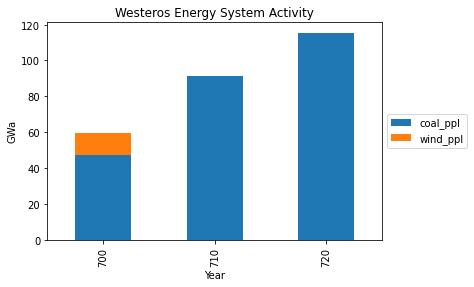

In [30]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

##### Contribution of end-use technologies on the activity
Considering the high price of the LED, all year generation are expected to be covered with bulbs

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

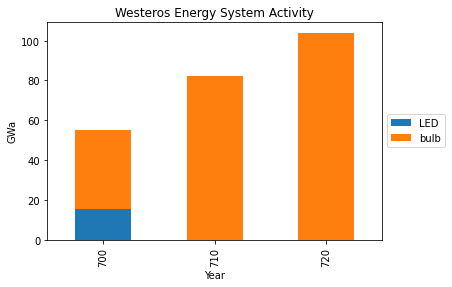

In [31]:
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

In [32]:
scenario.var('ACT')

,node_loc,technology,year_vtg,year_act,mode,time,lvl,mrg
0,Westeros,coal_ppl,690,700,standard,year,18.264840,0.000000
1,Westeros,coal_ppl,700,700,standard,year,29.109451,0.000000
2,Westeros,coal_ppl,700,710,standard,year,29.109451,0.000000
3,Westeros,coal_ppl,710,710,standard,year,62.001660,0.000000
4,Westeros,coal_ppl,710,720,standard,year,62.001660,0.000000
5,Westeros,coal_ppl,720,720,standard,year,53.553896,0.000000
6,Westeros,wind_ppl,690,700,standard,year,12.176560,0.000000
7,Westeros,wind_ppl,700,700,standard,year,0.000000,0.000000
8,Westeros,wind_ppl,700,710,standard,year,0.000000,0.000000
9,Westeros,wind_ppl,710,710,standard,year,0.000000,0.000000


##### Capacity

How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

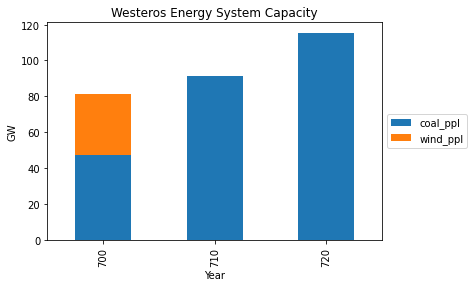

In [33]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot capacity")

##### New capacity

How much new capacity is installed in each period? Notice that the new installed capacity requires additional investments.

<AxesSubplot:title={'center':'Westeros Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

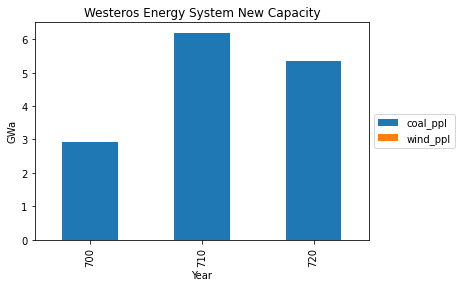

In [34]:
rep.get("plot new capacity")

##### Electricity Prices


<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

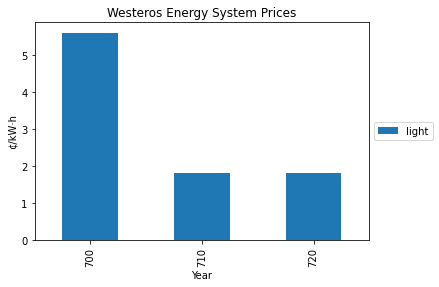

In [35]:
# Replace the technology filters with a commodity filter;
# show only "light" and not e.g. "electricity".
rep.set_filters(c=["light"])

# Create a price plot
rep.get("plot prices")

In [36]:
mp.close_db()

In [37]:
#scenario.var('DEMAND')

## 2. Carbon Pricing 

##### 2.1 Adding emission bounds

In [38]:
mp = ixmp.Platform()

In [39]:
model = "Westeros Electrified"

base = message_ix.Scenario(mp, model=model, scenario="baseline")
scen_emission = base.clone(
    model,
    "emission_bound",
    "introducing an upper bound on emissions",
    keep_solution=False,
)
scen_emission.check_out()

In [40]:
#introducing emission bounds
year_df = scen_emission.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen_emission.set("year")
country = "Westeros"

In [41]:
##introducing emissions
# First we introduce the emission of CO2 and the emission category GHG
scen_emission.add_set("emission", "CO2")
scen_emission.add_cat("emission", "GHG", "CO2")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

# Last we add CO2 emissions to the coal powerplant
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="coal_ppl",
    emission="CO2",
    value=7.4,
)
scen_emission.add_par("emission_factor", emission_factor)

##### 2.2 Adding emission taxes

In [42]:
scen_bd = message_ix.Scenario(mp, model=model, scenario="emission_bound")

In [43]:
emissions = scen_bd.var("EMISS", {"node": "Westeros"})

In [44]:
emission_prices = scen_bd.var("PRICE_EMISSION")

#### setting up tax instead of bound

In [45]:
## setting up tax instead of bound

scen_tax = base.clone(
    model, "carbon_tax", "introducing a carbon tax", keep_solution=False
)
scen_tax.check_out()

In [46]:
scen_tax.add_set("emission", "CO2")
scen_tax.add_cat("emission", "GHG", "CO2")
scen_tax.add_par("emission_factor", scen_bd.par("emission_factor"))

In [47]:
scen_tax.add_set("type_year", [700, 710, 720])

# In case you need to add the new unit to the platform
mp.add_unit("USD/tCO2")

tax_emission = make_df(
    "tax_emission",
    node="Westeros",
    type_year=[700, 710, 720],
    type_tec="all",
    unit="USD/tCO2",
    type_emission="GHG",
    value=[1000,1000,1000],
    #value=emission_prices.set_index("year").lvl,
)

scen_tax.add_par("tax_emission", tax_emission)
scen_tax.par("tax_emission")

,node,type_emission,type_tec,type_year,value,unit
0,Westeros,GHG,all,700,1000.0,USD/tCO2
1,Westeros,GHG,all,710,1000.0,USD/tCO2
2,Westeros,GHG,all,720,1000.0,USD/tCO2


In [48]:
scen_tax.commit(comment="setting taxes on emissions")
scen_tax.solve()

In [49]:
scen_tax.var("OBJ")["lvl"]

1762423.875

In [50]:
scen_tax.var("EMISS", {"node": "Westeros"})

,node,emission,type_tec,year,lvl,mrg
0,Westeros,CO2,all,700,177.397940,0.0
1,Westeros,CO2,all,710,6.737517,0.0
2,Westeros,CO2,all,720,0.000000,0.0


##### Plotting Again

In [51]:
rep2 = Reporter.from_scenario(scen_tax)
prepare_plots(rep2)

##### Contribution of the generation technologies on the activity

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

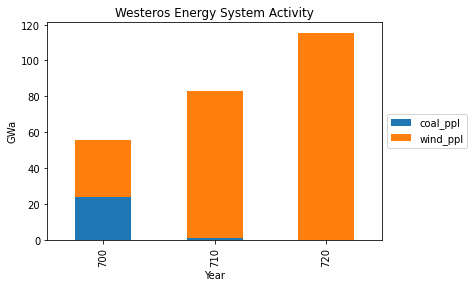

In [52]:
rep2.set_filters(t=["coal_ppl", "wind_ppl"])
rep2.get("plot activity")

##### Contribution of end-use technologies on the activity
Considering the high price of the LED, all year generation are expected to be covered with bulbs

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

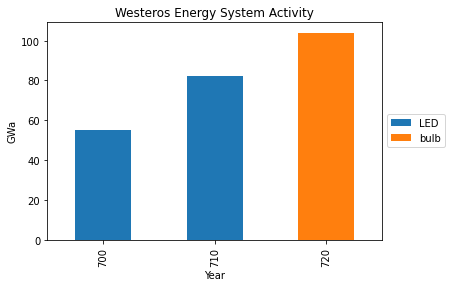

In [53]:
rep2.set_filters(t=["bulb", "LED"])
rep2.get("plot activity")

In [54]:
scen_tax.var('ACT')

,node_loc,technology,year_vtg,year_act,mode,time,lvl,mrg
0,Westeros,coal_ppl,690,700,standard,year,18.264840,0.000000
1,Westeros,coal_ppl,700,700,standard,year,5.707854,0.000000
2,Westeros,coal_ppl,700,710,standard,year,0.910475,0.000000
3,Westeros,coal_ppl,710,710,standard,year,0.000000,0.000000
4,Westeros,coal_ppl,710,720,standard,year,0.000000,20892.237165
5,Westeros,coal_ppl,720,720,standard,year,0.000000,20980.715364
6,Westeros,wind_ppl,690,700,standard,year,12.176560,0.000000
7,Westeros,wind_ppl,700,700,standard,year,19.406301,0.000000
8,Westeros,wind_ppl,700,710,standard,year,19.406301,0.000000
9,Westeros,wind_ppl,710,710,standard,year,62.511507,0.000000


##### Capacity

How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

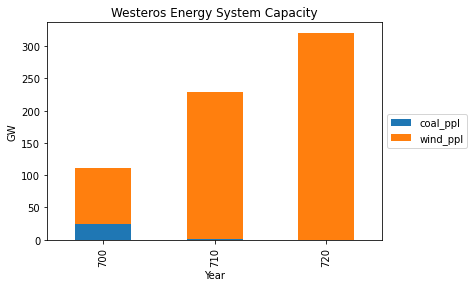

In [55]:
rep2.set_filters(t=["coal_ppl", "wind_ppl"])
rep2.get("plot capacity")

##### New capacity

How much new capacity is installed in each period? Notice that the new installed capacity requires additional investments.

<AxesSubplot:title={'center':'Westeros Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

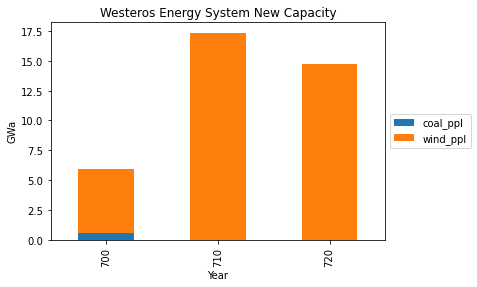

In [56]:
rep2.get("plot new capacity")

##### Electricity Prices


<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

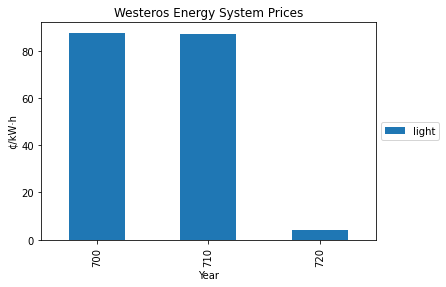

In [57]:
# Replace the technology filters with a commodity filter;
# show only "light" and not e.g. "electricity".
rep2.set_filters(c=["light"])

# Create a price plot
rep2.get("plot prices")

In [58]:
mp.close_db()

## 3. Changes in the diffusion rates of the technology (on baseline)
Relating the technology in the current period to the technology in the previous period

This section analyses the influence of the diffusion rates of the technology on the the share of the generation technologies. Different ranges of technology diffusion rates were analyzed based on literature. Considering the absence of historic values of LED, an initial year value was assigned to the technology 

In [59]:
mp = ixmp.Platform()

In [60]:
#mp.scenario_list()

In [61]:
## cloning the baseline scenarion (Note: The LED costs are high here)

base = message_ix.Scenario(mp, model=model, scenario="baseline")
scenario_diff = base.clone(
    model,
    keep_solution=False,
)

scenario_diff.check_out()

In [62]:
demand_per_year

54.794520547945204

### Diffusion rates assigned for led
The led_initial_activity_up results in the pre-defined existance of certain LED use such that future year growth is calculated based on it

In [63]:

## intital activity up for LED
df_led_initial_activity_up = make_df(
    "initial_activity_up",
        node_loc=country,
        year_act=model_horizon[0],
        time="year",
        unit="-",
        technology="LED",
        value=0.5,
    )
scenario_diff.add_par("initial_activity_up", df_led_initial_activity_up)

## adding LED growth rate
df_led_difussion = make_df(
        "growth_activity_up",
        node_loc=country,
        year_act=model_horizon,
        time="year",
        unit="-",
        technology='LED',
        value=0.23, ## based on literature lED diffusion rate is ~23% for every 10 years
    )
scenario_diff.add_par("growth_activity_up", df_led_difussion)  

In [64]:
log.info(f"version number before commit(): {scenario_diff.version}")

scenario_diff.commit(comment="basic model of Westeros electrification")

log.info(f"version number after commit(): {scenario_diff.version}")

In [65]:
scenario_diff.set_as_default()

In [66]:
scenario_diff.solve()

In [67]:
scenario_diff.var("OBJ")["lvl"]

169330.765625

In [68]:
rep = Reporter.from_scenario(scenario_diff)

# Add keys like "plot activity" to describe reporting operations.
# See tutorial/utils/plotting.py
from message_ix.util.tutorial import prepare_plots

prepare_plots(rep)

In [69]:
#rep.get('all')

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

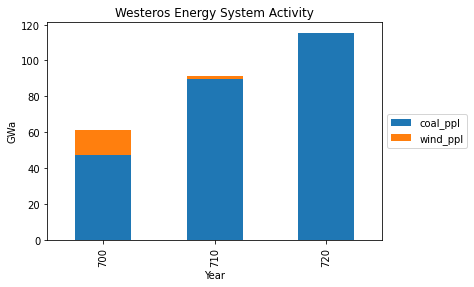

In [70]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot activity")

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

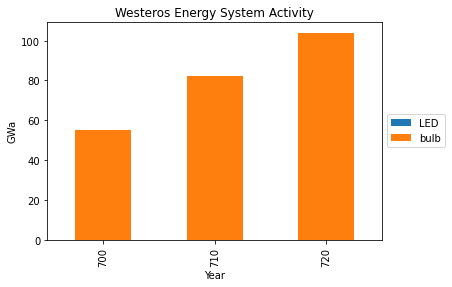

In [71]:
rep.set_filters(t=["bulb", "LED"])
rep.get("plot activity")

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

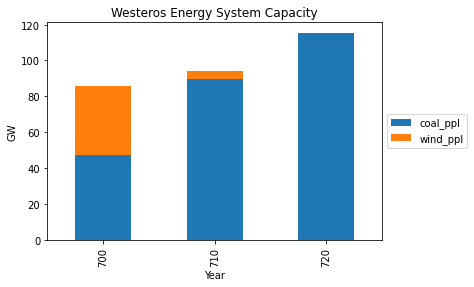

In [72]:
rep.set_filters(t=["coal_ppl", "wind_ppl"])
rep.get("plot capacity")

<AxesSubplot:title={'center':'Westeros Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

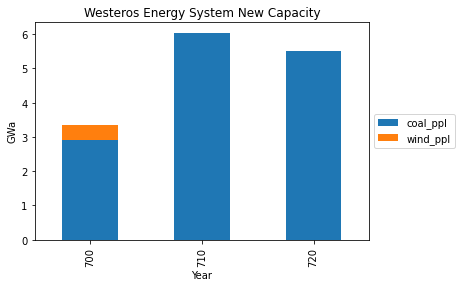

In [73]:
rep.get("plot new capacity")

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

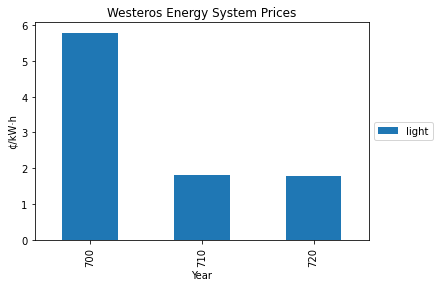

In [74]:
rep.set_filters(c=["light"])

# Create a price plot
rep.get("plot prices")

In [75]:
mp.close_db()

### Conclusions

1. To replicate the desired result of 100% supply from bulb even with the inclusion of LED technology, the cost of the LED had to be increased unrealistically (2000 times of the bulb). Else, due to higher benifits of LED with regards to efficeincy and lifetime, the model would still choose LED ( for all prices below 2000 times)

2. Due to the high costs assigned to the LED, realistic emission taxes did not seem to alter the model's decision to select LED over bulb though the generation did change to 100% Wind from coal.

3. The diffusion rate largely affects the changes in the combination of the generation technologies. With the increased diffiusion rate of the LED, the reduction in the activity is expected to provide higher share of Wind use and installation, compenstating for its lower capacity factor. However, implementing the diffusion rates in the baseline scenario, the effect is not seen as 1. the cost of LED is too high and 2. without the emission taxes wind is very expensive. However once the LED prices are reduced, increase in Wind Generation share is observed.








## Reference
[1] InLine Electric, 2022<br>
https://www.inlineelectric.com/lifespan#:~:text=One%20of%20the%20biggest%20advantages,for%20at%20least%2020%20years

[2] IIASA Energy, Climate, and Environment (ECE)<br>
https://docs.messageix.org/projects/global/en/latest/energy/tech.html



## License

   [<img style="float: right;" src="https://img.shields.io/badge/License-Apache%202.0-blue.svg">](https://opensource.org/licenses/Apache-2.0)

   Copyright 2022 Aadit Malla

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.